## Preface



First, load relevant dataset:



In [18]:
!pip install CFEDemands
import cfe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

USE = "Tanzania"

# Results can be made persistent by saving them, and then re-loading...
if USE=="Tanzania":
    DIR = "./TanzanianNPS/"
    r = cfe.from_dataset(DIR+'tanzanian_nps.ds')
    USE_GOOD = 'Ripe Bananas'
else:
    raise ValueError("No such value of USE")

fct = pd.read_pickle(DIR+'fct.df') #food conversion table
rda = pd.read_pickle(DIR+"rda.df")  

# Use prices, distribution of budgets from first round, first market:
t = r.firstround  # First round  
m = r.coords['m'][0] # First market

# Distribution of predicted total expenditures
xhat = r.get_predicted_expenditures().sum('i')   #total amount of resources given resources they have...
xhat = xhat.where(xhat>0,np.nan)

# Note selection of prices for first period and first market
p = r.prices.sel(t=t,m=m).fillna(1).copy()

def my_prices(p0,p=p,i=USE_GOOD):   #allows us to change the price one at a time
    p = p.copy()
    p.loc[i] = p0
    return p

# Now fix up FCT

# Change some labels in fct
d={'protein g':'Protein',
   'energy kcal':'Calories',
   'ca mg':'Calcium',
   'fe mg':'Iron',
   'zn mg': 'Zinc',
   'mg mg': 'Magnesium',
   'vit a ug':'Vitamin A',
  'vit e ug':'Vitamin E',
  'vit c mg':"Vitamin C",
  'vit b6 mg':'Vitamin B6',
   'vit b12 ug':'Vitamin B12'}

fct = fct.rename(columns=d) #[list(d.values())]

# Fix capitalization (to match food labels)
fct.index = fct.reset_index()['Item name'].str.title()

# Replace missing with zeros
fct = fct.fillna(0)

try:
    fct.index = fct.index.droplevel('unit')
except AttributeError: pass # No units?

def nutrient_demand(x,p,z=None):
    c = r.demands(x,p,z=z)  #vector of demands 
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0  #food conversion table and the vector of quantity demanded for a given x,p. 

    return N

# In first round, averaged over households and villages
zbar = r.z.sel(t=r.firstround).mean(['j','m'])[:-1] # Leave out log HSize    #zbar is avg characteristics of households. 
#for presentation it can be interesting to play with this or change this.

# This matrix product gives minimum nutrient requirements for average
# household in first round
hh_rda = rda.replace('',0).T@zbar  #rda is recommended daily allowance 

def nutrient_adequacy_ratio(x,p):
    return nutrient_demand(x,p)/hh_rda   

## Simple Policy Experiments



Consider two policies:  First, changing income so that some proportion
of the population achieves nutritional adequacy.  Here choose quantile
we&rsquo;re interested in (e.g., a quantile of 0.5 is the median; a quantile
of 0.25 is the household at the 25th percentage point of the distribution).



In [19]:
# A quantile of 0.5 is the median.  Play with quantile value, or just assign.
x0 = xhat.sel(t=t,m=m).quantile(0.01,'j') # Budget (median household)
x0 = 100      #code will figure out budget of the household with lowest 1% income

/srv/app/venv/lib/python3.6/site-packages/cfe/root_with_precision.py:85: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -4.00E+00.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps tolerance is too high?" % (tol,x[0]-x[-1],i))
/srv/app/venv/lib/python3.6/site-packages/cfe/root_with_precision.py:85: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -5.82E-11.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps tolerance is too high?" % (tol,x[0]-x[-1],i))


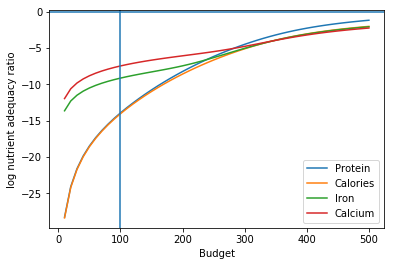

In [20]:
import matplotlib.pyplot as plt
import numpy as np

X = np.linspace(x0/10,x0*5,50)

UseNutrients = ['Protein','Calories','Iron','Calcium']
plt.plot(X,pd.concat({x:np.log(nutrient_adequacy_ratio(x,p))[UseNutrients] for x in X},axis=1).T)
plt.legend(UseNutrients)
plt.xlabel('Budget')
plt.ylabel('log nutrient adequacy ratio')
plt.axhline(0)
plt.axvline(x0)

#assumption is that if we increase x, the curves does not change --> which means that we need to make sure prices do not change as budget changes.

#assume supply is perfectly elastic - competition needed.




#if a household has 100 budget, and we want a policy for them to have nutritional adequacy, the recommended policy is income transfer 

As before, we can also vary relative prices.  Here we trace out
nutritional adequacy varying the price of a single good:



/srv/app/venv/lib/python3.6/site-packages/cfe/root_with_precision.py:85: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -1.91E-06.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps tolerance is too high?" % (tol,x[0]-x[-1],i))


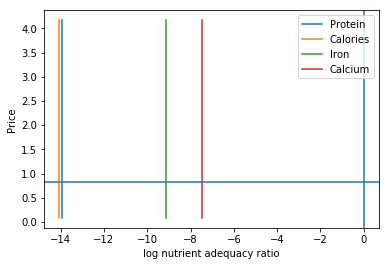

In [21]:
poorer_x = x0

# Choose reference (t,m) for reference good
ref_price = r.prices.sel(i=USE_GOOD,t=t,m=m)
P = np.linspace(ref_price/10,ref_price*5,50)

plt.plot(pd.concat({p0:np.log(nutrient_adequacy_ratio(poorer_x,my_prices(p0,i=USE_GOOD)))[UseNutrients] for p0 in P},axis=1).T,P)
plt.legend(UseNutrients)
plt.ylabel('Price')
plt.xlabel('log nutrient adequacy ratio')
plt.axvline(0)
plt.axhline(p.sel(i=USE_GOOD).values)

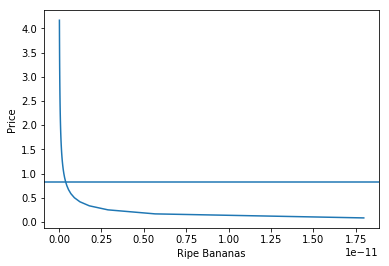

In [22]:
plt.plot([r.demands(poorer_x,my_prices(p0,i=USE_GOOD))[USE_GOOD] for p0 in P],P)
plt.ylabel('Price')
plt.xlabel(USE_GOOD)
plt.axhline(p.sel(i=USE_GOOD).values)

## Compensated Policy Experiments



/srv/app/venv/lib/python3.6/site-packages/cfe/root_with_precision.py:85: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -1.91E-06.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps tolerance is too high?" % (tol,x[0]-x[-1],i))


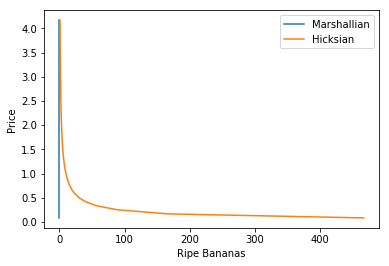

In [23]:
U0 = cfe.demands.marshallian.indirect_utility(x0,p,np.exp(r.alpha),r.beta,0)

plt.plot([r.demands(poorer_x,my_prices(p0,i=USE_GOOD))[USE_GOOD] for p0 in P],P)
plt.plot([r.demands(poorer_x,my_prices(p0,i=USE_GOOD),type="Hicksian")[USE_GOOD] for p0 in P],P)
plt.ylabel('Price')
plt.xlabel(USE_GOOD)
#plt.axhline(p.sel(i=USE_GOOD).values)
plt.legend(("Marshallian","Hicksian"))

In [24]:
def compensating_variation(U0,p0,p1):
    x0 = cfe.demands.hicksian.expenditurefunction(U0,p0,np.exp(r.alpha),r.beta,0)
    x1 =  cfe.demands.hicksian.expenditurefunction(U0,p1,np.exp(r.alpha),r.beta,0)

    return x1-x0

compensating_variation(U0,p,my_prices(.5))


#CV is how much money we need if there is a price change to get the original utility function
#consumers getting compensation for welfare consequences

#CV = p_tilde'h(U_knot,p_tilde)-p'h(U_knot,p) 
#CV =x1-x0


#ways to characterize cost
#a set of changes in price. 
#some houses will be made better off.

/srv/app/venv/lib/python3.6/site-packages/cfe/root_with_precision.py:85: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -1.91E-06.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps tolerance is too high?" % (tol,x[0]-x[-1],i))


-2.1316282072803006e-13

In [28]:
z_actual = r.z.sel(t=2008,m=1,j="0002-001")
z_actual.to_dataframe()
r.z.to_dataframe()


z
k         j               t    m          
C 0-2     0001-001        2008 1       NaN
                          2010 1       NaN
                          2012 1  0.000000
                          2014 1       NaN
          0002-001        2008 1       NaN
                          2010 1       NaN
                          2012 1  0.000000
                          2014 1       NaN
          0003-001        2008 1       NaN
                          2010 1       NaN
                          2012 1  0.000000
                          2014 1       NaN
          0003-010        2008 1       NaN
                          2010 1       NaN
                          2012 1  0.000000
                          2014 1       NaN
          0005-001        2008 1       NaN
                          2010 1       NaN
                          2012 1  0.000000
                          2014 1       NaN
          0006-001        2008 1       NaN
                          2010 1       NaN
                          2012 1  0.000000
                          2014 1       NaN
          0007-001        2008 1       NaN
                          2010 1       NaN
                          2012 1  0.000000
                          2014 1       NaN
          0008-001        2008 1       NaN
                          2010 1       NaN
...                                    ...
log HSize 905012325005802 2012 1       NaN
                          2014 1       NaN
          905012325005803 2008 1       NaN
                          2010 1  0.693147
                          2012 1       NaN
                          2014 1       NaN
          9050123250059   2008 1  1.098612
                          2010 1       NaN
                          2012 1       NaN
                          2014 1       NaN
          905012325005901 2008 1       NaN
                          2010 1  0.000000
                          2012 1       NaN
                          2014 1       NaN
          905012325005902 2008 1       NaN
                          2010 1  2.397895
                          2012 1       NaN
                          2014 1       NaN
          9050123250081   2008 1  1.098612
                          2010 1       NaN
                          2012 1       NaN
                          2014 1       NaN
          905012325008101 2008 1       NaN
                          2010 1  0.693147
                          2012 1       NaN
                          2014 1       NaN
          905012325008102 2008 1       NaN
                          2010 1  0.000000
                          2012 1       NaN
                          2014 1       NaN

[433984 rows x 1 columns]

In [26]:
def total_cv(U0,p0,p1):
    #insert list of households
    totalcv= {}
    for i in households:
        totalcv[i.household_ID] = compensating_variation(U0,p0,p1)
    print (totalcv)
    return
        